In [15]:
# Add Yarn package repository
!curl -sS https://dl.yarnpkg.com/debian/pubkey.gpg | sudo apt-key add -
!echo "deb https://dl.yarnpkg.com/debian/ stable main" | sudo tee /etc/apt/sources.list.d/yarn.list

!export NVM_DIR="$HOME/.nvm"
![ -s "$NVM_DIR/nvm.sh" ] && \. "$NVM_DIR/nvm.sh"
# Install Yarn
!sudo apt update
!sudo apt install yarn

OK
deb https://dl.yarnpkg.com/debian/ stable main
Get:1 https://download.docker.com/linux/ubuntu focal InRelease [57.7 kB]
Get:2 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease [1477 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:4 https://cli.github.com/packages stable InRelease                         
Get:5 https://dl.yarnpkg.com/debian stable InRelease [17.1 kB]                 
Hit:6 http://archive.ubuntu.com/ubuntu focal InReleasem                    
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [2006 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:10 https://dl.yarnpkg.com/debian stable/main all Packages [11.8 kB]m       
Get:11 https://dl.yarnpkg.com/debian stable/main amd64 Packages [11.8 kB]      
Get:12 http://archive.ubuntu.com/ubun

In [16]:
!pip install uv
!uv pip install -r requirements.txt
!uv pip install 'accelerate>=0.26.0'
!uv pip install torch
!uv pip install flash-attn==2.7.4.post1 --no-build-isolation
!./install_circuitsvis.sh
# please install yarn as per README.md

Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 7 packages in 16ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 6ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 4ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 5ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 5ms


In [2]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.set_grad_enabled(False)  # avoid blowing up mem
device = "cuda"

In [3]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceTB/SmolVLM-Instruct",
                                                torch_dtype=torch.bfloat16,
                                                _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager").to(DEVICE)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


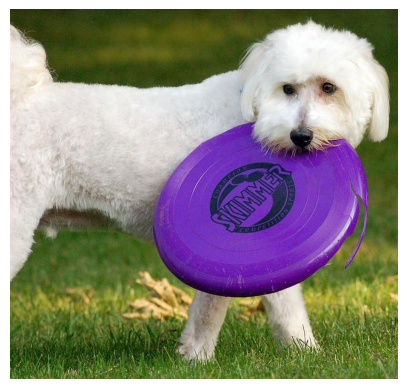

In [4]:
from PIL import Image
from transformers.image_utils import load_image

img_path = "imgs/frisbee.jpg"
image = load_image(img_path)
plt.axis("off")
_ = plt.imshow(image)

In [37]:
from getAttentionLib import get_response, get_attention, dump_attn, get_img_grid_sizes, plot_mult_attn_sums

text = "<image>Answer en what color is the frisbee?"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": text}
        ]
    },
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
model.to('cuda')

# Prepare inputs
inputs_tokens, response = get_response(model, processor, text, image)
print(inputs_tokens)
print(response)
# inputs = processor(text=prompt, images=[image1], return_tensors="pt")
# inputs = inputs.to(DEVICE)

# generated_ids = model.generate(**inputs, max_new_tokens=500)
# generated_texts = processor.batch_decode(
#     generated_ids,
#     skip_special_tokens=True,
# )

# print(generated_texts[0])

['<fake_token_around_image>', '<', 'row', '_', '1', '_', 'col', '_', '1', '>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<fake_token_around_image>', '

# Create Multimodal Attention Visualization

In [35]:
from getAttentionLib import get_response, get_attention_smol_lvm, dump_attn, get_img_grid_sizes, plot_mult_attn_sums

inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)

n_img_tokens, grid_side_len = get_img_grid_sizes(model, inputs)
for layer_idx in [0, 5, 10, 15, 20]:
    state, n_tokens = get_attention_smol_lvm(model, inputs, layer_idx=layer_idx)
    # print(state.outputs.shape, state.attn_weights.shape, inputs.input_ids.shape)
    dump_attn(
        state,
        layer_idx,
        name="SmolVLM",
        tokens=inputs_tokens,
        img_path=img_path,
        grid_side_len=grid_side_len,
    )

Rendered HTML
Wrote to file='SmolVLM_layer_0_attention_heads.html'
Rendered HTML
Wrote to file='SmolVLM_layer_5_attention_heads.html'
Rendered HTML
Wrote to file='SmolVLM_layer_10_attention_heads.html'
Rendered HTML
Wrote to file='SmolVLM_layer_15_attention_heads.html'
Rendered HTML
Wrote to file='SmolVLM_layer_20_attention_heads.html'


# Plot Region-wise Attention

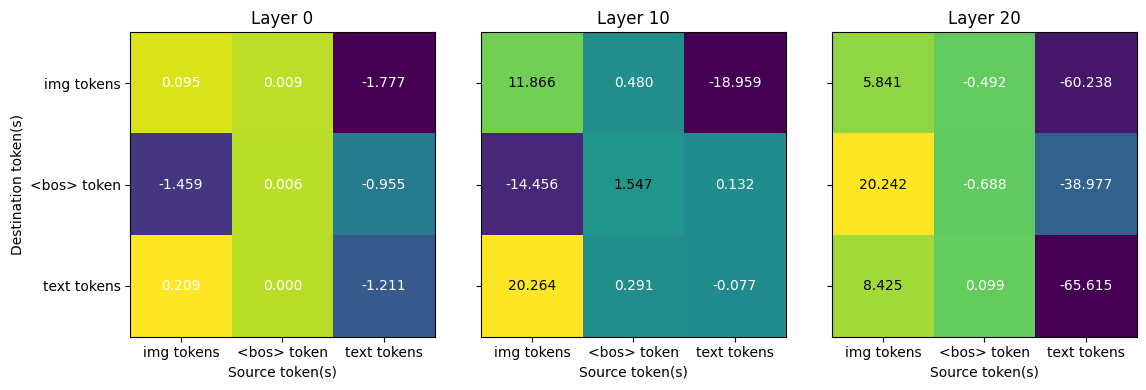

In [36]:
fig = plot_mult_attn_sums(model, inputs, layers=[0, 10, 20])
fig.savefig("imgs/blockwise-attn-sums-frisbee.png")
fig.show()

# Verify Numbers on VQA

In [52]:
import tqdm
from getAttentionLib import compute_mult_attn_sums, load_vqa_ds, plot_images_grid

n_vqa_samples = 15 # 1000
ds = load_vqa_ds(split="train")

layers = [0, 10, 20]
attens_tensor = []
responses = []
imgs = []
seen_imgs = set()
pbar = tqdm.tqdm(total=n_vqa_samples)
for row in ds:
    if len(imgs) >= n_vqa_samples:
        break

    if row["image_id"] in seen_imgs:
        continue
    seen_imgs.add(row["image_id"])

    text = f"{row['question']}"
    try:
        inputs = processor(text=text, images=row["image"], return_tensors="pt").to(model.device)
    except ValueError: # Unsupported number of image dimensions: 2
        continue

    response = get_response(model, processor, text, row["image"])[1]
    #responses.append(response.replace("\n", " A: ").replace("Answer en", "Q:"))
    responses.append(response)
    
    imgs.append(row["image"])
    
    mult_attn_sums = compute_mult_attn_sums(model, inputs, layers=layers)
    attens_tensor.append(torch.stack(mult_attn_sums))
    
    pbar.update(1)
pbar.close()
    
stacked_attens = torch.stack(attens_tensor)
assert stacked_attens.shape == (n_vqa_samples, len(layers), 3, 3)

Repo card metadata block was not found. Setting CardData to empty.
  0%|          | 0/15 [00:00<?, ?it/s]

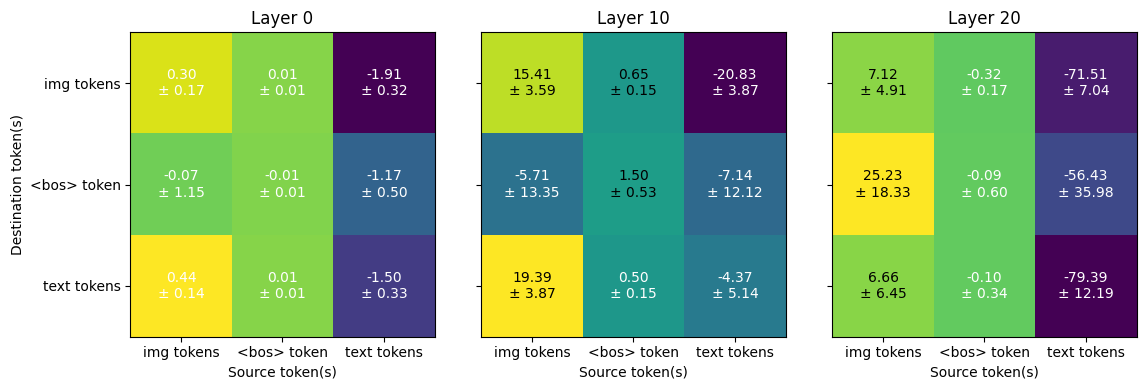

In [ ]:
means = stacked_attens.mean(dim=0)
assert means.shape == (len(layers), 3, 3)
stds = stacked_attens.std(dim=0)
assert stds.shape == (len(layers), 3, 3)
fig = plot_mult_attn_sums(None, None,layers=layers, mult_attn_sums=means, stds=stds)
fig.savefig("imgs/blockwise-attn-sums-vqa1000.png")
fig.show()

# Show VQA Grid

In [ ]:
import textwrap

def process_response(r: str) -> str:
    row_col_string, q_and_a = r.split("<global-img>Answer en")
    q = q_and_a.split("? ")[0]
    a = q_and_a.split("? ")[1:]
    chars_per_line = 20
    # Wrap text to fit within subplot
    q = textwrap.fill(q, width=chars_per_line)
    return f"Q: {q}\nA: {a}"

process_response(responses[0])

"Q:  What is this photo\ntaken looking\nthrough\nA: [' Fence.  Net.  Glove.  Ball.  Hat.  Uniform.  Glove.  Pitcher.  Arm.  Leg.  Hat.  Uniform.  Glove.  Ball.  Hat.  Uniform.  Glove.  Ball.  Hat.  Uniform.  Glove.  Ball.  Hat.  Uniform.  Glove.  Ball.  Hat.  Uniform.  Glove.  Ball. ']"

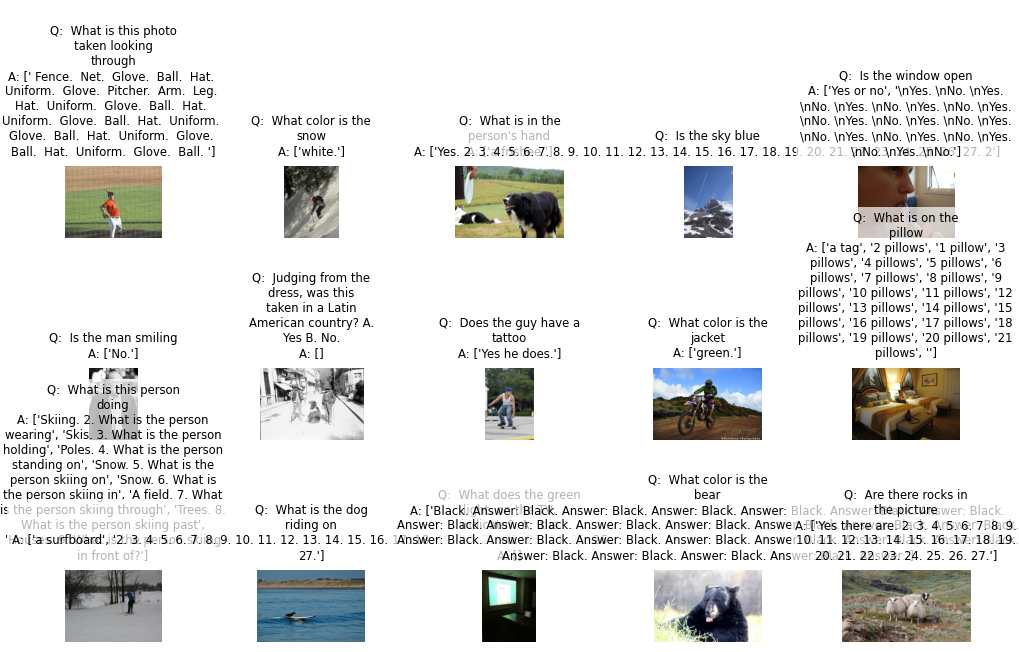

In [51]:
proc_responses = [process_response(r) for r in responses]
fig = plot_images_grid(imgs[:15], proc_responses[:15], nrows=3, ncols=5, figsize=(10, 6))
fig.savefig("imgs/vqa-grid-of-img-question-answer.png")
fig.show()